In [12]:
import sklearn
import seaborn as sns
import pandas as pd
import statistics as stat
from copy import deepcopy
from random import randint

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, scale, PolynomialFeatures, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, ClusterCentroids, EditedNearestNeighbours, CondensedNearestNeighbour, RepeatedEditedNearestNeighbours, RandomUnderSampler

# Configuration
pd.set_option('display.max_columns', 40) # Hacer que pandas muestre 40 columnas de un dataframe

---

<center><h2>Cargar Dataset</h2></center>

---

In [9]:
#URL_TRAIN_CSV = "https://gitlab.com/villainnumber1/filesml_proyecto_2/-/raw/main/train.csv"
#URL_TEST_CSV = "https://gitlab.com/villainnumber1/filesml_proyecto_2/-/raw/main/test.csv"
URL_TRAIN_CSV = "https://filebin.net/0f9iskt93peq0g1h/train_clean.csv"
URL_TEST_CSV  = "https://filebin.net/0f9iskt93peq0g1h/test_clean.csv"

X = pd.read_csv(URL_TRAIN_CSV, sep=",")
Y = pd.read_csv(URL_TEST_CSV, sep=",")

---

<center><h2>Exploración de Datos</h2></center>

---

Empezamos anlizando las columnas para ver si tienen algun valor nulo.

In [ ]:
#
# Cosas para esta sección:
#   1. Columnas nulas
#   2. Columnas con muchos outliers
#   3. Datos raros
#   4. Diagramas de caja y bigotes
#   5. Diagramas de kde
#   6. Diagrama de calor
#   7. Clasificación dos a dos
#

#X.info()

ID lo podemos ignorar por razones obvias. Customer_ID parece ser única para cada cliente ya que hay una correspondencia 1:1 con su número de seguridad social.

In [ ]:
s = {}

for i, row in X.iterrows():
  id = row["Customer_ID"]
  ssn = row["SSN"]

  if id not in s:
    s[id] = set()

  s[id].add(ssn)

print("Clientes con más de un SSN:", len([ id for id in s if len(s[id]) > 1]))

Clientes con más de un SSN: 0


La columna Month parece seguir una distribución parecida a la uniforme donde todos tienen una densidad similar. Sugiere que no va a tener demasiado uso.

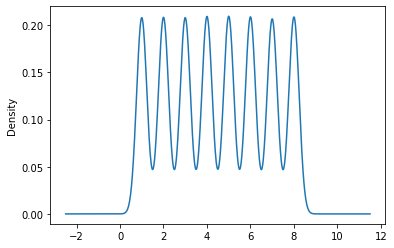

In [ ]:
X.Month.plot.kde()

La columna de Name tiene una correspondencia 1:1 con Customer_ID lo cual sugiere que deberíamos dropearla por la misma razón. Además intuitivamente no parece que el nombre de una persona vaya a influenciar su crédito bancario. TODO: Comprobar correlación.

In [ ]:
s = {}

for i, row in X.iterrows():
  id = row["Customer_ID"]
  ssn = row["Name"]

  if id not in s:
    s[id] = set()

  s[id].add(ssn)

print("Clientes con más de un nombre:", len([ id for id in s if len(s[id]) > 1]))

Clientes con más de un nombre: 0


Intuitivamente la columna Age parece que puede tener relación con el crédito bancario de un cliente, ya que las personas por debajo de un determinado umbral de edad probablemente no tengan demasiado patrimonio. Investigándola más a fondo hemos descubierto que hay 4710 clientes con una edad de 14 a 18 años lo cual es ilegal en USA donde necesitas 18 años para poder ser adjudicado una valoración de crédito bancario, lo cual nos hace pensar que ha ocurrido una anonimización de datos. Es posible que tengamos que hacer algo con esos valores.

In [ ]:
len([ 1 for i, row in X.iterrows() if row["Age"] < 18 ])

4628

In [ ]:
# TODO: Grafico con barras y su valor más frecuente

Como hemos visto antes, SSN también tiene una correspondencia 1:1 con Nombre y Customer_ID lo cual sugiere el mismo tratamiento. Tambien podemos ver que gráficamente son muy parecidas. En el caso de normalizarse deberían tener prácticamente las mismas curvas.

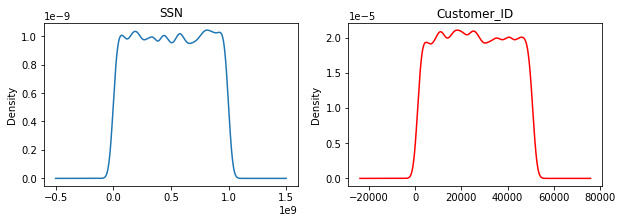

In [8]:
import matplotlib.pyplot as plt

fix, axs = plt.subplots(1, 2, figsize=(10, 3))

#X.Occupation.hist()
#X.Occupation.value_counts()
X.SSN.plot.kde(ax=axs[0], title="SSN")
#print("a"*100000)
X.Customer_ID.plot.kde(ax=axs[1], color="red", title="Customer_ID")

Como podemos ver en la columna Occupation casi todas las categorías tienen una frecuencia parecida. Intuitivamente podemos pensar que la ocupación tendrá algo de influencia en el crédito bancario pero un poco de investigación sugiere que no es algo que suelan tener en cuenta para el calculo del mismo en USA.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


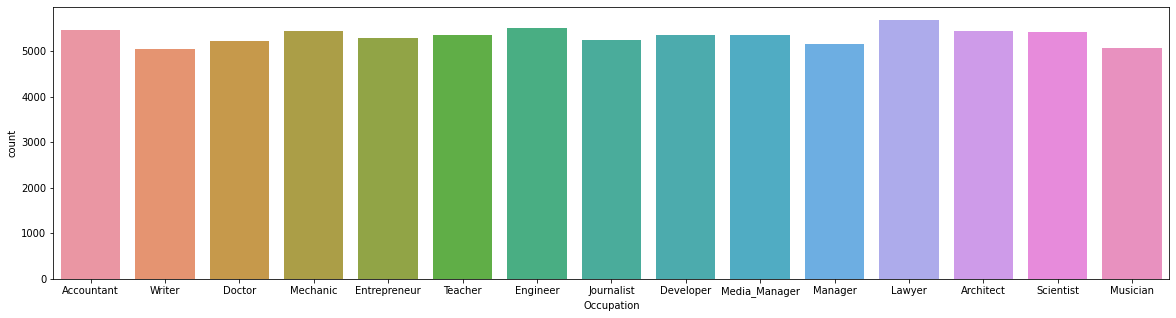

In [18]:
# pasar a seaborn
#X.Occupation.value_counts()

fig0, axs0 = plt.subplots(ncols=1)
fig0.set_figwidth(20)
fig0.set_figheight(5)

aux = sns.countplot(X["Occupation"], ax=axs0)

In [6]:
X.groupby("Occupation").Credit_Score.value_counts()


Occupation     Credit_Score
Accountant     Standard        2846
               Poor            1637
               Good             974
Architect      Standard        2979
               Poor            1480
               Good             976
Developer      Standard        2874
               Poor            1508
               Good             965
Doctor         Standard        2851
               Poor            1449
               Good             925
Engineer       Standard        2785
               Poor            1692
               Good            1026
Entrepreneur   Standard        2697
               Poor            1623
               Good             965
Journalist     Standard        2749
               Poor            1501
               Good             997
Lawyer         Standard        3107
               Poor            1569
               Good            1006
Manager        Standard        2700
               Poor            1487
               Good             959


---

<center><h2>Transformación de Columnas</h2></center>

---

In [10]:
normalizer = StandardScaler(with_mean=False)

def unionColumnas(df1, df2, columnName):
  l = list(set(df1[columnName]).union(set(df2[columnName])))
  return l, [ columnName + "_" + str(x) for x in l ]


#
# Tanto las arrays con _ al principio como keysTotales son solo para métricas
#
keysAge,   _keysAge        = unionColumnas(X, Y, "Age")
keysOccupation, _keysOccupation = unionColumnas(X, Y, "Occupation")
keysPMA,   _keysPMA        = unionColumnas(X, Y, "Payment_of_Min_Amount")
keysCM,    _keysCM         = unionColumnas(X, Y, "Credit_Mix")
keysPB,    _keysPB         = unionColumnas(X, Y, "Payment_Behaviour")
keysNBA,   _keysNBA        = unionColumnas(X, Y, "Num_Bank_Accounts")
keysNCC,   _keysNCC        = unionColumnas(X, Y, "Num_Credit_Card")
keysIR,    _keysIR         = unionColumnas(X, Y, "Interest_Rate")
keysNOL,   _keysNOL        = unionColumnas(X, Y, "Num_of_Loan")
keysIR,    _keysIR         = unionColumnas(X, Y, "Interest_Rate")
keysNDP,   _keysNDP        = unionColumnas(X, Y, "Num_of_Delayed_Payment")
keysNCI,   _keysNCI        = unionColumnas(X, Y, "Num_Credit_Inquiries")
keysCHA,   _keysCHA        = unionColumnas(X, Y, "Credit_History_Age")
keysMonth, _keysMonth      = unionColumnas(X, Y, "Month")
keysDFDD,  _keysDFDD       = unionColumnas(X, Y, "Delay_from_due_date")

keysTotales = ["Customer_ID", "Month"] + _keysOccupation + ["Annual_Income"] + _keysNBA + _keysNCC + _keysIR + _keysNOL\
            + ["Delay_from_due_date"] + _keysNDP + ["Changed_Credit_Limit"] + _keysNCI + _keysCM + ["Outstanding_Debt", "Credit_Utilization_Ratio"]\
            + _keysCHA + _keysPMA + ["Total_EMI_per_Month", "Amount_Invested_Monthly"] + _keysPB + ["Monthly Balance"]\
            + ["Auto Loans", "Credit Builder Loans", "Debt Consolidation Loans", "Home Equity Loans", "Mortage Loans", "Payday Loans", "Personal Loans", "Student Loans"]

# Transformar las columnas
# TODO: Considerar ensembles para mismos clientes?
# TODO: Considerar OrdinalEncoder para features del estilo Good-Normal-Bad
transformersX = [
  ("ID",                                              "drop",                                                       [0]),    # Por razones obvias
  ("Customer_ID",                                     "passthrough",                                                [1]),    # Por razones obvias
  ("Month",                                           "passthrough",                                                [2]),    # No creo que tenga ninguna influencia
  ("Name",                                            "drop",                                                       [3]),    # No tiene influencia y está repetida
  ("Age",                                             "drop",                                                       [4]),
  ("SSN",                                             "drop",                                                       [5]),    # No tiene influencia y está repetida
  ("Occupation",                                      OneHotEncoder(categories=[keysOccupation]),                   [6]),    # No deberia influir, pero baja un poco el error? TODO: Comprobar
  ("Annual_Income",                                   "passthrough",                                                [7]),
  ("Monthly_Inhand_Salary",                           "drop",                                                       [8]),    # Annual_Income/12
  ("Num_Bank_Accounts",                               OneHotEncoder(categories=[keysNBA]),                          [9]),    # No tiene influencia
  ("Num_Credit_Card",                                 OneHotEncoder(categories=[keysNCC]),                          [10]),
  ("Interest_Rate",                                   OneHotEncoder(categories=[keysIR]),                           [11]),
  ("Num_of_Loan",                                     OneHotEncoder(categories=[keysNOL]),                          [12]),
  ("Type_of_Loan",                                    "drop",                                                       [13]),   # Dividida
  ("Delay_from_due_date",                             "passthrough",                                                [14]),   # No va bien por onehot
  ("Num_of_Delayed_Payment",                          "passthrough",                                                [15]),   # Mejor sin onehot
  ("Changed_Credit_Limit",                            "passthrough",                                                [16]),
  ("Num_Credit_Inquiries",                            OneHotEncoder(categories=[keysNCI]),                          [17]),
  ("Credit_Mix",                                      OneHotEncoder(categories=[keysCM]),                           [18]),
  ("Outstanding_Debt",                                "passthrough",                                                [19]),
  ("Credit_Utilization_Ratio",                        "passthrough",                                                [20]),
  ("Credit_History_Age",                              OneHotEncoder(categories=[keysCHA]),                          [21]),
  ("Payment_of_Min_Amount",                           OneHotEncoder(categories=[keysPMA]),                          [22]),   # No va bien con passthrough
  ("Total_EMI_per_Month",                             "passthrough",                                                [23]),
  ("Amount_Invested_Monthly",                         "passthrough",                                                [24]),   # No tiene influencia
  ("Payment_Behaviour",                               OneHotEncoder(categories=[keysPB]),                           [25]),
  ("Monthly_Balance",                                 "passthrough",                                                [26]),
  ("Credit_Score",                                    "drop",                                                       [27]),

  # Type_of_Loan
  ("_Auto_Loans",                                     "passthrough", [28]),
  ("_Credit-Builder_Loans",                           "passthrough", [29]),
  ("_Debt_Consolidation_Loans",                       "passthrough", [30]),
  ("_Home_Equity_Loans",                              "passthrough", [31]),
  ("_Mortgage_Loans",                                 "passthrough", [32]),
  ("_Payday_Loans",                                   "passthrough", [33]),
  ("_Personal_Loans",                                 "passthrough", [34]),
  ("_Student_Loans",                                  "passthrough", [35]),
]
    
transformersY = deepcopy(transformersX)

# Normbrar el orden de columnas de 0 a n-1
transformersY.pop(27) # Eliminar Credit_Score
for i, t in enumerate(transformersY): # Renumerar los indices de las columnas
  transformersY[i][2].pop()
  transformersY[i][2].append(i)

X_T = ColumnTransformer(transformers=transformersX).fit_transform(X)
Y_T = ColumnTransformer(transformers=transformersY).fit_transform(Y)

print(X_T.shape)
print(Y_T.shape)

######################
# Normalize the data #
######################
X_T = normalizer.fit_transform(X_T)
Y_T = normalizer.fit_transform(Y_T)

(80000, 177)
(20000, 177)


---

<center><h2>Entrenamiento y Prediccion</h2></center>

---

La primera decisión que tomamos fue si era necesario hacer sampling, y para ello estudiamos si nuestro dataset presentaba algún tipo de desbalanceo. Inicialmente el dataset presenta esta disposión.

In [11]:
Credit_Score = X["Credit_Score"]

def proporcion (Credit_Score):
  print("Poor     :", len([x for x in Credit_Score if x == "Poor"]))     
  print("Standard :", len([x for x in Credit_Score if x == "Standard"]))       
  print("Good     :", len([x for x in Credit_Score if x == "Good"]))

proporcion(Credit_Score)     

Poor     : 23199
Standard : 42539
Good     : 14262


Podemos observar que el número de muestras de Standard es bastante superior al resto lo que sugiere un desbalanceo. 
Para resolver este problemas nos vimos obligados a usar sampling.

---

<center><h2>Sampling</h2></center>

---

En primer lugar consultamos que algoritmo de sampling era más prometedor y que ajustes se adaptaban mejor a nuestro caso, asi que empezamos a probar difentes aproximaciones. Aquí dejamos una lista con los principales algoritmos utilizados.

# OVERSAMBLING

1.   SMOTE
2.   ADASYN
3.   BorderlineSMOTE
4.   RandomOverSampler
5.   KMeansSMOTE

# UNDERSAMBLING

1.   TomekLinks
2.   ClusterCentroids
3.   CondensedNearestNeighbour
4.   RepeatedEditedNearestNeighbours
5.   RandomUnderSampler
6.   NearMiss



Probamos más algoritmos de undersambling porque fue lo que mejor resultado nos proporciono.


<center><h2>OverSampling</h2></center>


Aquí mostramos los mejores ajustes que hemos conseguido para cada algoritmo de oversambling.

In [13]:
_X_T = X_T
_Credit_Score = X["Credit_Score"]

display("1. SMOTE:")
resampler = SMOTE(sampling_strategy={"Good": 20000}, random_state=42, k_neighbors=2)
SMOTE_X_T, SMOTE_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(SMOTE_Credit_Score)

##########################################################################################################################################################

display("2. ADASYN:")
resampler = ADASYN(sampling_strategy = 'not majority', random_state=42)
ADASYN_X_T, ADASYN_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(ADASYN_Credit_Score)

##########################################################################################################################################################

display("3. BorderlineSMOTE:")
resampler = BorderlineSMOTE(sampling_strategy = 'not majority', random_state=42)
BorderlineSMOTE_X_T, BorderlineSMOTE_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(BorderlineSMOTE_Credit_Score)

##########################################################################################################################################################

display("4. RandomOverSampler:")
resampler = RandomOverSampler(sampling_strategy = 'not majority', random_state=42)
RandomOverSampler_X_T, RandomOverSampler_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(RandomOverSampler_Credit_Score)

##########################################################################################################################################################

display("5. KMeansSMOTE:")
resampler = KMeansSMOTE(sampling_strategy = 'not majority', random_state=42)
KMeansSMOTE_X_T, KMeansSMOTE_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(KMeansSMOTE_Credit_Score)

'1. SMOTE:'

Poor     : 23199
Standard : 42539
Good     : 20000


'2. ADASYN:'

Poor     : 43936
Standard : 42539
Good     : 41042


'3. BorderlineSMOTE:'

Poor     : 42539
Standard : 42539
Good     : 42539


'4. RandomOverSampler:'

Poor     : 42539
Standard : 42539
Good     : 42539


'5. KMeansSMOTE:'

Poor     : 42541
Standard : 42539
Good     : 42542


<center><h2>UnderSampling</h2></center>

In [ ]:
_X_T = X_T
_Credit_Score = X["Credit_Score"]

display("1. TomekLinks")
resampler = TomekLinks(sampling_strategy=["Standard"], n_jobs=-1)
TomekLinks_X_T, TomekLinks_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(TomekLinks_Credit_Score)

display("2. ClusterCentroids")
resambler = ClusterCentroids(sampling_strategy=["Standard"], n_jobs=-1)
ClusterCentroids_X_T, ClusterCentroids_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(ClusterCentroids_Credit_Score)

display("3. CondensedNearestNeighbour")
resampler = CondensedNearestNeighbour(sampling_strategy=["Standard"], n_jobs=-1)
CondensedNearestNeighbour_X_T, CondensedNearestNeighbour_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(CondensedNearestNeighbour_Credit_Score)

display("4. RepeatedEditedNearestNeighbours")
resampler = TomekLinks(sampling_strategy=["Standard"], n_jobs=-1)
RepeatedEditedNearestNeighbours_X_T, RepeatedEditedNearestNeighbours_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(RepeatedEditedNearestNeighbours_Credit_Score)

display("5. RandomUnderSampler")
resampler = TomekLinks(sampling_strategy=["Standard"], n_jobs=-1)
RandomUnderSampler_X_T, RandomUnderSampler_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(RandomUnderSampler_Credit_Score)

display("6. NearMiss")
resampler = TomekLinks(sampling_strategy=["Standard"], n_jobs=-1)
NearMiss_X_T, NearMiss_Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(NearMiss_Credit_Score)

display("7. TomekLinks")
resampler = TomekLinks(sampling_strategy=["Standard"], n_jobs=-1)
_X_T, _Credit_Score = resampler.fit_resample(_X_T, _Credit_Score)
proporcion(ClusterCentroids_Credit_Score)

---

<center><h2>Score</h2></center>

---

In [ ]:
scoring = {
    "precision_micro" : make_scorer(precision_score, average = 'micro'),
    "recall_micro"    : make_scorer(recall_score,    average = 'micro'),
    "precision_macro" : make_scorer(precision_score, average = 'macro'),
    "recall_macro"    : make_scorer(recall_score,    average = 'macro'),
    "f1_micro"        : make_scorer(f1_score,        average = 'micro'),
    "f1_macro"        : make_scorer(f1_score,        average = 'macro')
}

def print_detailed(scores, cv):
    # Añadir medias
    precision_micro = scores["test_precision_micro"].tolist() + [stat.mean(scores["test_precision_micro"]), ""]
    recall_micro    = scores["test_recall_micro"].tolist()    + [stat.mean(scores["test_recall_micro"]),    ""]
    precision_macro = scores["test_precision_macro"].tolist() + [stat.mean(scores["test_precision_macro"]), ""]
    recall_macro    = scores["test_recall_macro"].tolist()    + [stat.mean(scores["test_recall_macro"]),    ""]
    f1_micro        = scores["test_f1_micro"].tolist()        + [stat.mean(scores["test_f1_micro"]),  stat.variance(scores["test_f1_micro"])**(1/2)]
    f1_macro        = scores["test_f1_macro"].tolist()        + [stat.mean(scores["test_f1_macro"]),  stat.variance(scores["test_f1_macro"])**(1/2)]
    
    rf_score = pd.DataFrame()
    rf_score.insert(0, "precision_micro", precision_micro)
    rf_score.insert(1, "recall_micro",    recall_micro)
    rf_score.insert(2, "f1_micro",        f1_micro)
    rf_score.insert(3, "precision_macro", precision_macro)
    rf_score.insert(4, "recall_macro",    recall_macro)
    rf_score.insert(5, "f1_macro",        f1_macro)
    
    rf_score.index = [str(n) for n in range(cv)] + ["avg", "std"]
    
    display(rf_score)

Una vez decididos los datos que vamos a tratar el siguiente paso que hemos seguido ha sido probar varios modelos.

Al mismo tiempo realizabamos pruebas con hiperparámetros para mejorar el proceso de entreno, principalmente hemos usado un GridSearch y RandomSearch, para encontrar los valores que mejor se adapten a nuestro modelo. LLegando a hacer busquedas superiores a las 2 hora, hemos añadido versiones similares a las que hemos ido utilizando.

**TODO: Intentar Nevergrad**


<h2>RandomizedSearchCV</h2>


In [ ]:
param_grid={
    "n_estimators": range(50, 100, 20),
    "min_samples_leaf": [1, 2],
    "min_samples_split": [2],
    "max_depth": range(50, 70, 10)
}

_clf = RandomForestClassifier(n_estimators=50, random_state=42)  

cv = RandomizedSearchCV(_clf, param_grid, random_state=42, n_jobs=-1, scoring="f1_micro")
cv.fit(_X_T, _Credit_Score)

display("Best score: ", cv.best_score_)
display("Best parameters:", cv.best_params_)

<h2>GridSearchCV</h2>

In [ ]:
param_grid={
    "n_estimators": range(50, 100, 25),
    "max_depth": [50,70],
    "min_samples_split": [1,2],
    "min_samples_leaf": [1,2],
}

rf = RandomForestClassifier(n_jobs=-1, random_state=42)  

gs = GridSearchCV(rf, param_grid, verbose=1, n_jobs=2, cv=5)

gs.fit(_X_T, _Credit_Score)

display("Best score: ", gs.best_score_)
display("Best parameters:", gs.best_params_)


Hemos usado cross-validation con 5 particiones para reducir el riesgo de overfitting.
